# Chatbot using Seq2Seq LSTM models
In this notebook, we will assemble a seq2seq LSTM model using Keras Functional API to create a working Chatbot which would answer questions asked to it.

Chatbots have become applications themselves. You can choose the field or stream and gather data regarding various questions. We can build a chatbot for an e-commerce webiste or a school website where parents could get information about the school.


Messaging platforms like Allo have implemented chatbot services to engage users. The famous [Google Assistant](https://assistant.google.com/), [Siri](https://www.apple.com/in/siri/), [Cortana](https://www.microsoft.com/en-in/windows/cortana) and [Alexa](https://www.alexa.com/) may have been build using simialr models.

So, let's start building our Chatbot.


## 1) Importing the packages

We will import [TensorFlow](https://www.tensorflow.org) and our beloved [Keras](https://www.tensorflow.org/guide/keras). Also, we import other modules which help in defining model layers.






In [1]:

import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import glob
from tensorflow.keras import layers , activations , models , preprocessing, utils
import os
import yaml
import pickle
from gensim.models import Word2Vec
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:

# dir_path = './Datasets'

questions = list()
answers = list()

for filepath in glob.glob('./Datasets/*.yml'):
    stream = open( filepath , 'rb')
    docs = yaml.safe_load(stream)
    conversations = docs['conversations']
    for con in conversations:
        if len( con ) > 2 :
            questions.append(con[0])
            replies = con[ 1 : ]
            ans = ''
            for rep in replies:
                ans += ' ' + rep
            answers.append( ans )
        elif len( con )> 1:
            questions.append(con[0])
            answers.append(con[1])

answers_with_tags = list()
for i in range( len( answers ) ):
    if type( answers[i] ) == str:
        answers_with_tags.append( answers[i] )
    else:
        questions.pop( i )

answers = list()
for i in range( len( answers_with_tags ) ) :
    answers.append( '<START> ' + answers_with_tags[i] + ' <END>' )

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( questions + answers )
VOCAB_SIZE = len( tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))


VOCAB SIZE : 1448


In [3]:

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


### C) Preparing data for Seq2Seq model

Our model requires three arrays namely `encoder_input_data`, `decoder_input_data` and `decoder_output_data`.

For `encoder_input_data` :
* Tokenize the `questions`. Pad them to their maximum length.

For `decoder_input_data` :
* Tokenize the `answers`. Pad them to their maximum length.

For `decoder_output_data` :

* Tokenize the `answers`. Remove the first element from all the `tokenized_answers`. This is the `<START>` element which we added earlier.



In [4]:


vocab = []
for word in tokenizer.word_index:
    vocab.append( word )

def tokenize( sentences ):
    tokens_list = []
    vocabulary = []
    for sentence in sentences:
        sentence = sentence.lower()
        sentence = re.sub( '[^a-zA-Z]', ' ', sentence )
        tokens = sentence.split()
        vocabulary += tokens
        tokens_list.append( tokens )
    return tokens_list , vocabulary

#p = tokenize( questions + answers )
#model = Word2Vec( p[ 0 ] ) 

#embedding_matrix = np.zeros( ( VOCAB_SIZE , 100 ) )
#for i in range( len( tokenizer.word_index ) ):
    #embedding_matrix[ i ] = model[ vocab[i] ]

# encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences( questions )
maxlen_questions = max( [ len(x) for x in tokenized_questions ] )
padded_questions = preprocessing.sequence.pad_sequences( tokenized_questions , maxlen=maxlen_questions , padding='post' )
encoder_input_data = np.array( padded_questions )
print( encoder_input_data.shape , maxlen_questions )

# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
maxlen_answers = max( [ len(x) for x in tokenized_answers ] )
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
decoder_input_data = np.array( padded_answers )
print( decoder_input_data.shape , maxlen_answers )

# decoder_output_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
for i in range(len(tokenized_answers)) :
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
onehot_answers = utils.to_categorical( padded_answers , VOCAB_SIZE )
decoder_output_data = np.array( onehot_answers )
print( decoder_output_data.shape )


(807, 13) 13
(807, 85) 85
(807, 85, 1448)


In [5]:


# Split the data into training and validation sets
encoder_input_train, encoder_input_val, decoder_input_train, decoder_input_val, decoder_output_train, decoder_output_val = train_test_split(encoder_input_data, decoder_input_data, decoder_output_data, test_size=0.15,random_state=42)

print("Shape of encoder_input_train:", encoder_input_train.shape)
print("Shape of encoder_input_val:", encoder_input_val.shape)
print("Shape of decoder_input_train:", decoder_input_train.shape)
print("Shape of decoder_input_val:", decoder_input_val.shape)
print("Shape of decoder_output_train:", decoder_output_train.shape)
print("Shape of decoder_output_val:", decoder_output_val.shape)


Shape of encoder_input_train: (685, 13)
Shape of encoder_input_val: (122, 13)
Shape of decoder_input_train: (685, 85)
Shape of decoder_input_val: (122, 85)
Shape of decoder_output_train: (685, 85, 1448)
Shape of decoder_output_val: (122, 85, 1448)


## 3) Defining the Encoder-Decoder model
The model will have Embedding, LSTM and Dense layers. The basic configuration is as follows.


*   2 Input Layers : One for `encoder_input_data` and another for `decoder_input_data`.
*   Embedding layer : For converting token vectors to fix sized dense vectors. **( Note :  Don't forget the `mask_zero=True` argument here )**
*   LSTM layer : Provide access to Long-Short Term cells.

Working : 

1.   The `encoder_input_data` comes in the Embedding layer (  `encoder_embedding` ). 
2.   The output of the Embedding layer goes to the LSTM cell which produces 2 state vectors ( `h` and `c` which are `encoder_states` )
3.   These states are set in the LSTM cell of the decoder.
4.   The decoder_input_data comes in through the Embedding layer.
5.   The Embeddings goes in LSTM cell ( which had the states ) to produce seqeunces.



<center><img style="float: center;" src="https://cdn-images-1.medium.com/max/1600/1*bnRvZDDapHF8Gk8soACtCQ.gif"></center>


Image credits to [Hackernoon](https://hackernoon.com/tutorial-3-what-is-seq2seq-for-text-summarization-and-why-68ebaa644db0).










In [6]:

encoder_inputs = tf.keras.layers.Input(shape=( maxlen_questions , ))
encoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 200 , return_state=True )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=( maxlen_answers ,  ))
decoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 200 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 200 , return_state=True , return_sequences=True )
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( VOCAB_SIZE , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 85)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 13, 200)      289600      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 85, 200)      289600      ['input_2[0][0]']                
                                                                                              

In [7]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="LSTM_SEQ2SEQ_Chatbot.h5",
    monitor='val_loss',
    verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', # Metric to monitor
    patience=5, # Number of epochs with no improvement after which training will be stopped
    verbose=1
)

In [8]:
log_dir = "./Run/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [9]:

history = model.fit([encoder_input_train , decoder_input_train], decoder_output_train,validation_data=([encoder_input_val , decoder_input_val],decoder_output_val), batch_size=64, epochs=250,callbacks=[checkpoint_callback,early_stopping, tensorboard_callback] ) 


Epoch 1/250
11/11 [==============================] - ETA: 0s - loss: 2.1394 - accuracy: 0.0660
Epoch 1: saving model to LSTM_SEQ2SEQ_Chatbot.h5
11/11 [==============================] - 72s 1s/step - loss: 2.1394 - accuracy: 0.0660 - val_loss: 1.8363 - val_accuracy: 0.0578
Epoch 2/250
11/11 [==============================] - ETA: 0s - loss: 1.8593 - accuracy: 0.0571
Epoch 2: saving model to LSTM_SEQ2SEQ_Chatbot.h5
11/11 [==============================] - 2s 206ms/step - loss: 1.8593 - accuracy: 0.0571 - val_loss: 1.5283 - val_accuracy: 0.0549
Epoch 3/250
11/11 [==============================] - ETA: 0s - loss: 1.7126 - accuracy: 0.0511
Epoch 3: saving model to LSTM_SEQ2SEQ_Chatbot.h5
11/11 [==============================] - 4s 398ms/step - loss: 1.7126 - accuracy: 0.0511 - val_loss: 1.5063 - val_accuracy: 0.0883
Epoch 4/250
11/11 [==============================] - ETA: 0s - loss: 1.6877 - accuracy: 0.0697
Epoch 4: saving model to LSTM_SEQ2SEQ_Chatbot.h5
11/11 [==========================

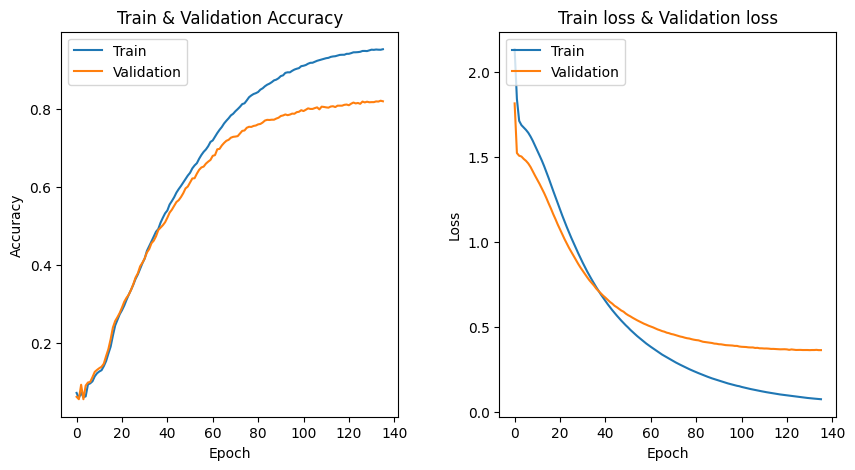

In [11]:
# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Train & Validation Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train','Validation'], loc='upper left')

# plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Train loss & Validation loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train','Validation'], loc='upper left')

# adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# show the plot
plt.show()

In [12]:

def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 200 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 200 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model([decoder_inputs] + decoder_states_inputs,[decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model


## 6) Talking with our Chatbot

First, we define a method `str_to_tokens` which converts `str` questions to Integer tokens with padding.


In [13]:

def str_to_tokens( sentence : str ):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
        tokens_list.append( tokenizer.word_index[ word ] ) 
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=maxlen_questions , padding='post')


In [ ]:

enc_model , dec_model = make_inference_models()

for _ in range(10):
    states_values = enc_model.predict( str_to_tokens( input( 'Enter question : ' ) ),verbose=0 )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values,verbose=0 )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in tokenizer.word_index.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    print( decoded_translation[:-3] )



## 7) Conversion to TFLite ( Optional )

We can convert our seq2seq model to a TensorFlow Lite model so that we can use it on edge devices.
